In [1]:
#Importing libraries
from typing import List, Tuple
import numpy as np
import pandas as pd
from typing import List, Optional
from tqdm import tqdm
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb
import catboost as catb
from catboost.utils import get_roc_curve
from catboost import Pool
import lightgbm as lgb
from boostaroota import BoostARoota

import os
import json
import shap
import dill
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from PIL import  Image
import missingno as msno
%matplotlib inline

import seaborn as sns #visualization
import featuretools as ft
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

from featexp import get_univariate_plots

from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold
from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency, ks_2samp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer, log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder as le
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 400)
plt.style.use('seaborn-whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def plot_roc_curve(**kwargs):
    res_lst = []
    
    for k, v in kwargs.items():  
        fpr, tpr, _ = roc_curve(v[0], v[1])
        res_lst.append((fpr, tpr, k))
    
    plt.figure(figsize=(20,10))
    for res in res_lst:
        plt.plot(res[0], res[1], label=res[2])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
    return res_lst

In [4]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                          params,
                          groups: pd.Series = pd.Series()):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
    groups:
        Если в cv_strategy передаем GroupKFold, то нужно передать groups,
        чтобы разделять по этим данным датасет на группы

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    if len(groups) > 0:
        cv_generator = cv_strategy.split(X, y, groups)
    else:
        cv_generator = cv_strategy.split(X, y)

    for fold_number, (train_idx, valid_idx) in enumerate(cv_generator):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        
        dtrain = xgb.DMatrix(data=x_train, label=y_train)
        dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
        
        model_train = estimator.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=1000,
            early_stopping_rounds=50,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=False,
            maximize=True,
        )
        y_train_pred = model_train.predict(dtrain)
        y_valid_pred = model_train.predict(dvalid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model_train)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

__Задание 0:__ выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [5]:
#Загружаю обработанные в ДЗ5 датасеты:
train = pd.read_csv("assignment2_data/train5.csv")
lb = pd.read_csv("assignment2_data/lb5.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("train.shape = {} rows, {} cols".format(*lb.shape))

train.shape = 179977 rows, 469 cols
train.shape = 100001 rows, 469 cols


In [6]:
#Разбиваем признаки по типам: числовые, нечисловые, цель
num_features = train.select_dtypes("number").columns.to_list()
dum_features = train.select_dtypes("object").columns.to_list()
target = num_features.pop(1)
len(num_features), len(dum_features), target

(446, 22, 'isFraud')

Датасет лидерборда для моделей:

In [7]:
y_lb = lb[target]
lb_train = lb[num_features + dum_features].apply(le().fit_transform)
dleaderboard = xgb.DMatrix(
    data=lb_train, label=y_lb
)

- Сделаю валидацию GroupKFold: 

In [8]:
data = train[num_features + dum_features].apply(le().fit_transform)
y = train[target]
groups = train['user_id']

In [9]:
cv_strategy = GroupKFold(n_splits=5)

In [10]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
#     "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [61]:
%%time
estimators1, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, y, xgb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, groups=groups
)

Fold: 1, train-observations = 143981, valid-observations = 35996
train-score = 0.9278, valid-score = 0.886
Fold: 2, train-observations = 143981, valid-observations = 35996
train-score = 0.9321, valid-score = 0.8819
Fold: 3, train-observations = 143982, valid-observations = 35995
train-score = 0.9258, valid-score = 0.8924
Fold: 4, train-observations = 143982, valid-observations = 35995
train-score = 0.9268, valid-score = 0.8963
Fold: 5, train-observations = 143982, valid-observations = 35995
train-score = 0.9289, valid-score = 0.8895
CV-results train: 0.9283 +/- 0.002
CV-results valid: 0.8892 +/- 0.005
OOF-score = 0.8895
Wall time: 22min 34s


In [62]:
lb_roc_auc_lst = []
for est in estimators1:
    y_lb_pred = est.predict(dleaderboard)
    lb_roc_auc_lst.append(roc_auc_score(y_lb, y_lb_pred))
print(lb_roc_auc_lst)
print('Leaderboard score', round(np.mean(lb_roc_auc_lst), 4),  '+/-', round(np.std(lb_roc_auc_lst), 3))

[0.8597555916378966, 0.8551583355383794, 0.8564870609729659, 0.8552639886470266, 0.8527549063109814]
Leaderboard score 0.8559 +/- 0.002


__Задание 1:__ использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

- Посмотрим на важность признаков по одному из фолдов:

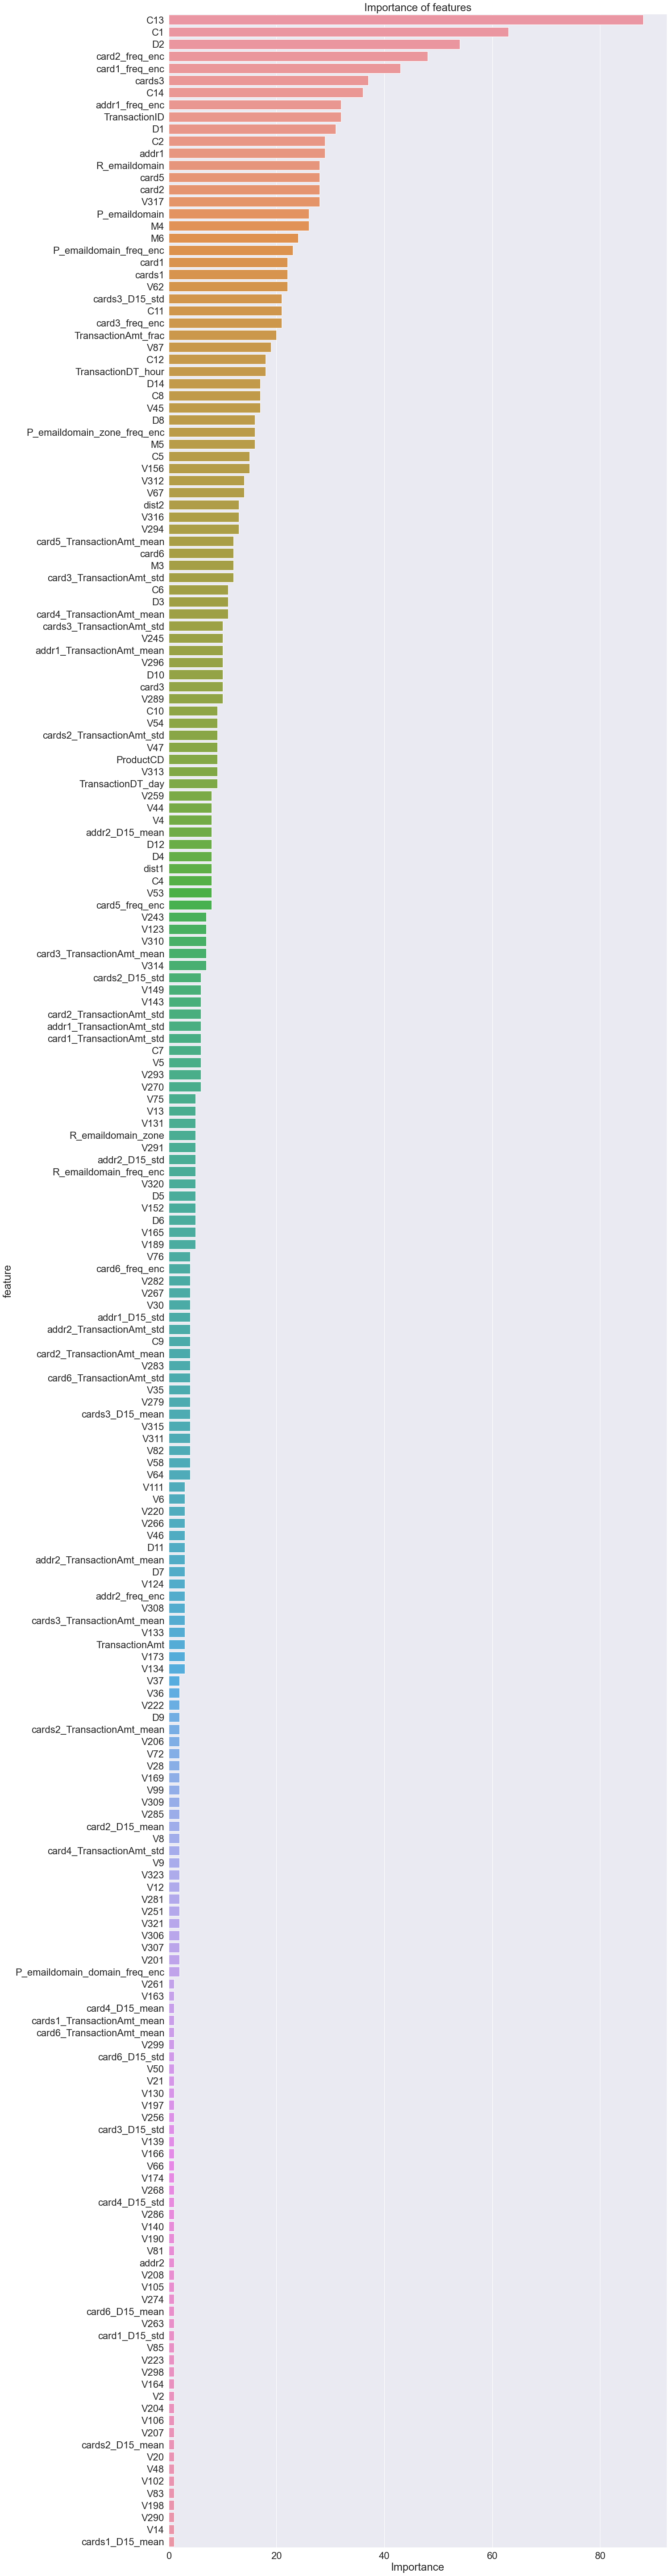

In [42]:
#weight
sns.set(font_scale = 2)
feature_important = estimators[0].get_score(importance_type='weight')
important_features_top1 = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)
sns.set(font_scale = 1)

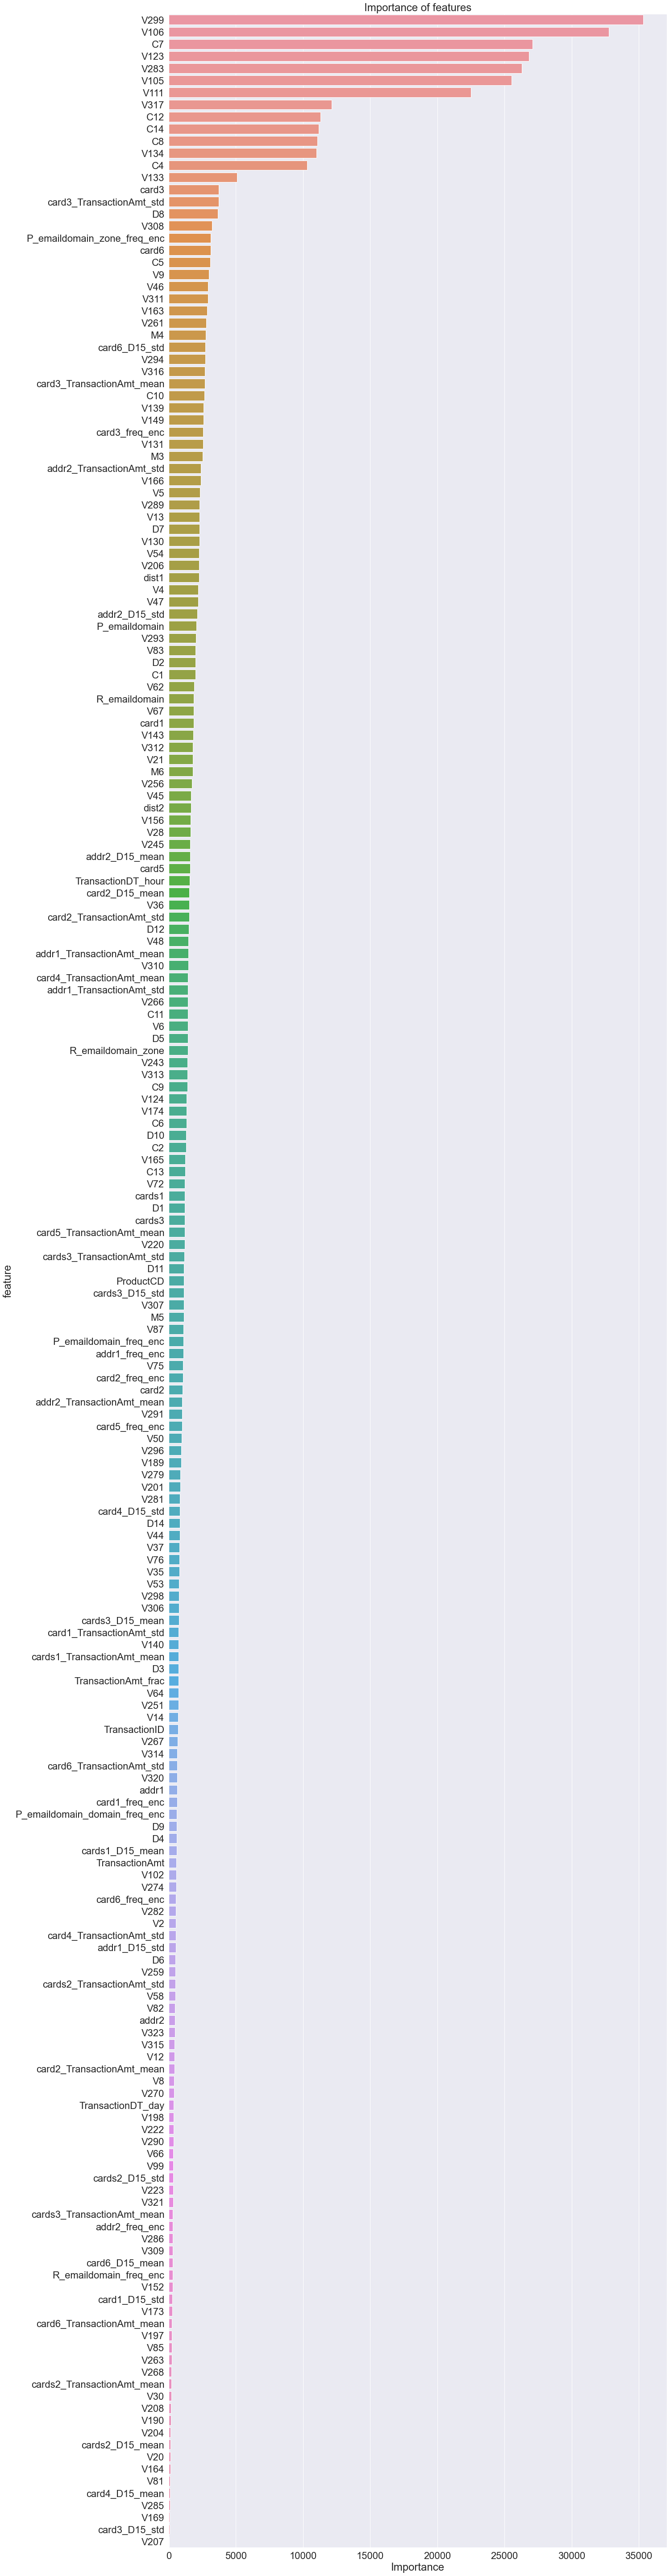

In [43]:
#cover
sns.set(font_scale = 2)
feature_important = estimators[0].get_score(importance_type='cover')
important_features_top2 = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)
sns.set(font_scale = 1)

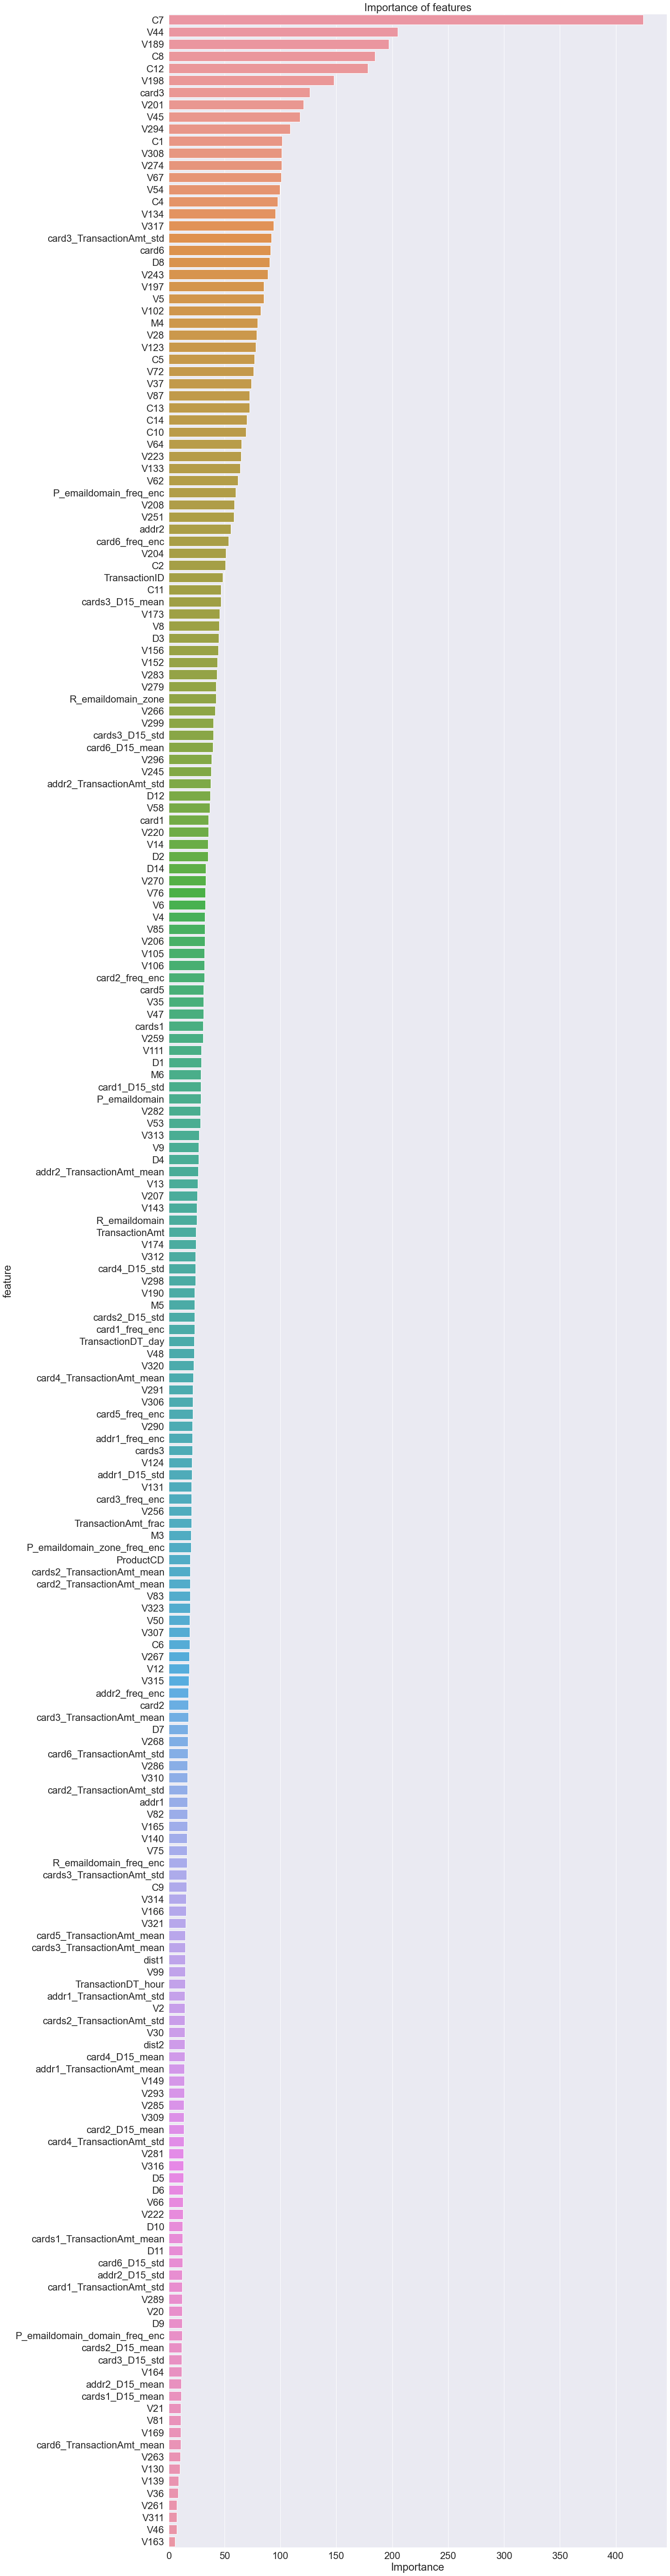

In [44]:
#gain
sns.set(font_scale = 2)
feature_important = estimators[0].get_score(importance_type='gain')
important_features_top3 = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)
sns.set(font_scale = 1)

- ТОП10 признаков кардинально отличается для каждого типа взвешивания признаков:

In [41]:
print('Weight:', important_features_top1[:10])
print('Cover:', important_features_top2[:10])
print('Gain:', important_features_top3[:10])

Weight: ['C13', 'C1', 'D2', 'card2_freq_enc', 'card1_freq_enc', 'cards3', 'C14', 'addr1_freq_enc', 'TransactionID', 'D1']
Cover: ['V299', 'V106', 'C7', 'V123', 'V283', 'V105', 'V111', 'V317', 'C12', 'C14']
Gain: ['C7', 'V44', 'V189', 'C8', 'C12', 'V198', 'card3', 'V201', 'V45', 'V294']


__Задание 2:__ удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

- Возьмем для примера ТОП30 признаков по всем типам взвешивания:

In [107]:
cols = set(important_features_top1 + important_features_top2 + important_features_top3)
len(cols)

70

In [54]:
data = train[cols].apply(le().fit_transform)

In [55]:
%%time
estimators2, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, y, xgb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, groups=groups
)

Fold: 1, train-observations = 143981, valid-observations = 35996
train-score = 0.9215, valid-score = 0.8786
Fold: 2, train-observations = 143981, valid-observations = 35996
train-score = 0.916, valid-score = 0.8781
Fold: 3, train-observations = 143982, valid-observations = 35995
train-score = 0.9147, valid-score = 0.8883
Fold: 4, train-observations = 143982, valid-observations = 35995
train-score = 0.9193, valid-score = 0.8949
Fold: 5, train-observations = 143982, valid-observations = 35995
train-score = 0.9173, valid-score = 0.8835
CV-results train: 0.9178 +/- 0.002
CV-results valid: 0.8847 +/- 0.006
OOF-score = 0.8854
Wall time: 6min 44s


In [56]:
y_lb = lb[target]
lb_train = lb[cols].apply(le().fit_transform)
dleaderboard = xgb.DMatrix(
    data=lb_train, label=y_lb
)

In [57]:
lb_roc_auc_lst = []
for est in estimators:
    y_lb_pred = est.predict(dleaderboard)
    lb_roc_auc_lst.append(roc_auc_score(y_lb, y_lb_pred))
print(lb_roc_auc_lst)
print('Leaderboard score', round(np.mean(lb_roc_auc_lst), 4),  '+/-', round(np.std(lb_roc_auc_lst), 3))

[0.8598436336178212, 0.8572394943639305, 0.855917581644668, 0.8534236550724363, 0.8559027756712925]
Leaderboard score 0.8565 +/- 0.002


- Обучение происходит на порядок быстрее, чем со всеми признаками.
- Выбор этих признаков оказал небольшое положительное влияние на качестве лидерборда (с 0.8544 до 0.8565), сохранив разброс на том же уровне

__Задание 3:__ использовать permutation importance, выполнить задание 1 и 2

In [93]:
def _predict(estimator, x_valid):
    if hasattr(estimator, "predict_proba"):
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.

    """
    x_valid_dmatrix = xgb.DMatrix(data=x_valid, label=y_valid)
    y_pred = _predict(estimator, x_valid_dmatrix)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in x_valid.columns:
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])
        x_valid_dmatrix = xgb.DMatrix(data=x_valid_, label=y_valid)

        y_pred = _predict(estimator, x_valid_dmatrix)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

In [94]:
scores, importance = calculate_permutation_importance(
    estimators1[0], roc_auc_score, data, y
)

- Получили 172 важных признака:

In [99]:
important_cols = importance[importance>0].index.to_list()
len(important_cols)

172

In [100]:
data = train[important_cols].apply(le().fit_transform)

In [101]:
%%time
estimators3, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, y, xgb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, groups=groups
)

Fold: 1, train-observations = 143981, valid-observations = 35996
train-score = 0.9304, valid-score = 0.8902
Fold: 2, train-observations = 143981, valid-observations = 35996
train-score = 0.93, valid-score = 0.8793
Fold: 3, train-observations = 143982, valid-observations = 35995
train-score = 0.9252, valid-score = 0.8877
Fold: 4, train-observations = 143982, valid-observations = 35995
train-score = 0.9263, valid-score = 0.8913
Fold: 5, train-observations = 143982, valid-observations = 35995
train-score = 0.9266, valid-score = 0.885
CV-results train: 0.9277 +/- 0.002
CV-results valid: 0.8867 +/- 0.004
OOF-score = 0.8865
Wall time: 8min 23s


In [104]:
y_lb = lb[target]
lb_train = lb[important_cols].apply(le().fit_transform)
dleaderboard = xgb.DMatrix(
    data=lb_train, label=y_lb
)

In [106]:
lb_roc_auc_lst = []
for est in estimators3:
    y_lb_pred = est.predict(dleaderboard)
    lb_roc_auc_lst.append(roc_auc_score(y_lb, y_lb_pred))
print(lb_roc_auc_lst)
print('Leaderboard score', round(np.mean(lb_roc_auc_lst), 4),  '+/-', round(np.std(lb_roc_auc_lst), 3))

[0.8551679424780994, 0.8562792157680895, 0.8541775491117526, 0.8525778973193886, 0.8563650059720705]
Leaderboard score 0.8549 +/- 0.001


- На валидационной выборке метрика практически не изменилась, но уменьшился разброс
- На лидерборде метрика ухудшилась по сравнению с выбором признаком по внутренним методам 

__Задание 4:__ использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.

In [13]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()
    
    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X

- Весь датасет с обработкой OHE у меня не помещается в память ноута. Поэтому я взял только исходные признаки датасета. В память поместилось, но выдается другая ошибка, решения которой я не нашел.

In [11]:
all_cols = train.columns.tolist()
only_cols = all_cols[:394]+['user_id']

In [14]:
data = prepare_data(train[only_cols])

In [15]:
%%time
br = BoostARoota(metric='auc', cutoff=5)
br.fit(data, y)

[12:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[12:49:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[12:50:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to som

XGBoostError: [12:52:57] C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:567: Check failed: mparam_.num_feature != 0 (0 vs. 0) : 0 feature is supplied.  Are you using raw Booster interface?

In [55]:
br.keep_vars_

In [56]:
data_br = br.transform(data)

ValueError: You need to fit the model first

__Задание 5:__ использовать shap, выполнить задание 1 и 2.

In [31]:
data = train[num_features + dum_features].apply(le().fit_transform)
y = train[target]

In [32]:
x_train, x_valid = train_test_split(data, train_size=0.7, random_state=48)
y_train, y_valid = train_test_split(y, train_size=0.7, random_state=48)

In [33]:
%%time
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

Wall time: 2min 7s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=6, nthread=6,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=100,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [35]:
explainer = shap.TreeExplainer(model)

In [80]:
shap_values = explainer.shap_values(x_valid, y_valid)
expected_value = explainer.expected_value

In [37]:
shap.initjs()

In [81]:
shap.force_plot(
    expected_value, shap_values[0,:], x_valid.iloc[0,:], link="logit"
)

In [67]:
shap_df = pd.DataFrame(
    np.abs(shap_values).mean(0), 
    index=x_valid.columns, 
    columns=['shap']
).sort_values(by='shap', ascending=False)

In [72]:
imp_shap_cols = shap_df.loc[shap_df['shap']>0].index.tolist()
print(f'Take from {shap_df.shape[0]} features {len(imp_shap_cols)} important features')

Take from 468 features 163 important features


In [74]:
data = train[imp_shap_cols].apply(le().fit_transform)
y = train[target]

In [76]:
%%time
estimators4, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data, y, xgb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, groups=groups
)

Fold: 1, train-observations = 143981, valid-observations = 35996
train-score = 0.9266, valid-score = 0.8869
Fold: 2, train-observations = 143981, valid-observations = 35996
train-score = 0.9306, valid-score = 0.8836
Fold: 3, train-observations = 143982, valid-observations = 35995
train-score = 0.927, valid-score = 0.8918
Fold: 4, train-observations = 143982, valid-observations = 35995
train-score = 0.9288, valid-score = 0.8977
Fold: 5, train-observations = 143982, valid-observations = 35995
train-score = 0.9251, valid-score = 0.8908
CV-results train: 0.9276 +/- 0.002
CV-results valid: 0.8902 +/- 0.005
OOF-score = 0.8902
Wall time: 8min 24s


In [77]:
y_lb = lb[target]
lb_train = lb[imp_shap_cols].apply(le().fit_transform)
dleaderboard = xgb.DMatrix(
    data=lb_train, label=y_lb
)

In [78]:
lb_roc_auc_lst = []
for est in estimators4:
    y_lb_pred = est.predict(dleaderboard)
    lb_roc_auc_lst.append(roc_auc_score(y_lb, y_lb_pred))
print(lb_roc_auc_lst)
print('Leaderboard score', round(np.mean(lb_roc_auc_lst), 4),  '+/-', round(np.std(lb_roc_auc_lst), 3))

[0.8597248182775823, 0.8538491054552256, 0.8563376649304272, 0.8530085795286872, 0.8545283643262418]
Leaderboard score 0.8555 +/- 0.002


- На валидационной выборке метрика стала лучше, чем при других метриках оценок качества выше
- Но на лидерборде результат ниже, чем при внутреннем методе оценки значимости признаков

__Задание 6:__ построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

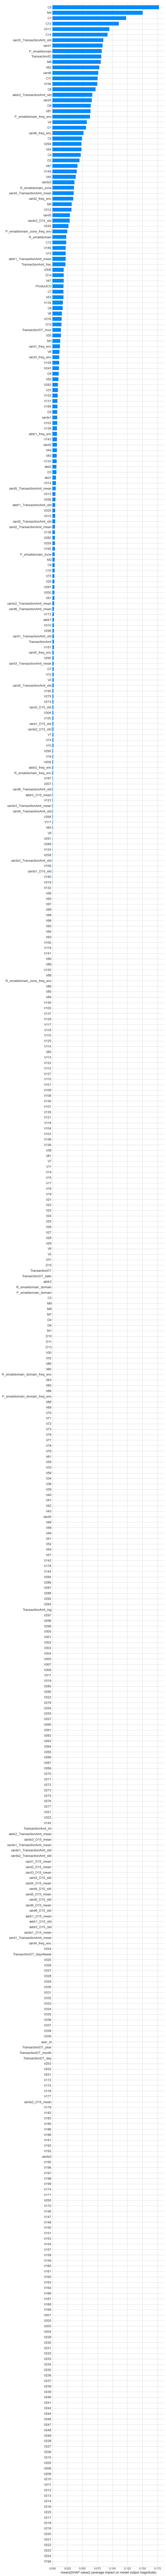

In [39]:
#Не понимаю, для чего строить график на небольшой выборке - построил на всей:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

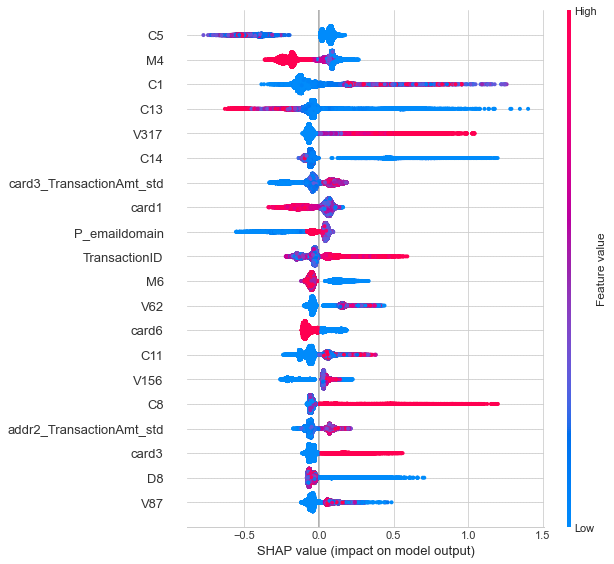

In [79]:
shap.summary_plot(shap_values, x_valid)

Рассмотрим самые важные признаки:
- C5 - более высокие значения признака вносят отрицательный вклад, а меньшие значения вносят положительный вклад, но не столь существенный
- M4 - похожая на С5 ситуация: довольно много высоких значений вносят отрицательный и много низких значений - вносят положительный вклад
- С1 - здесь ситуация обратная C5
- и т.д.

В целом в части признаках ситуация похожая - разного уровня значения оказывают разного уровня влияние, а в некоторых - значения перемешаны. При этом нет ни одного признака, где была бы большая плотность значений с нулевым вкладом

In [86]:
select = range(20)
features = x_valid.iloc[select]
features_display = x_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [91]:
shap_values.shape

(20, 468)

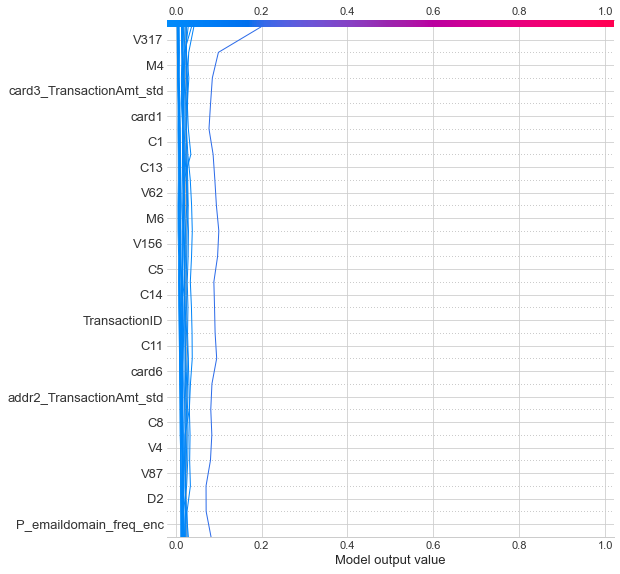

In [89]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20], link='logit'
)

- На графике выше виден один выброс среди 20 значений по всем выведенным признакам

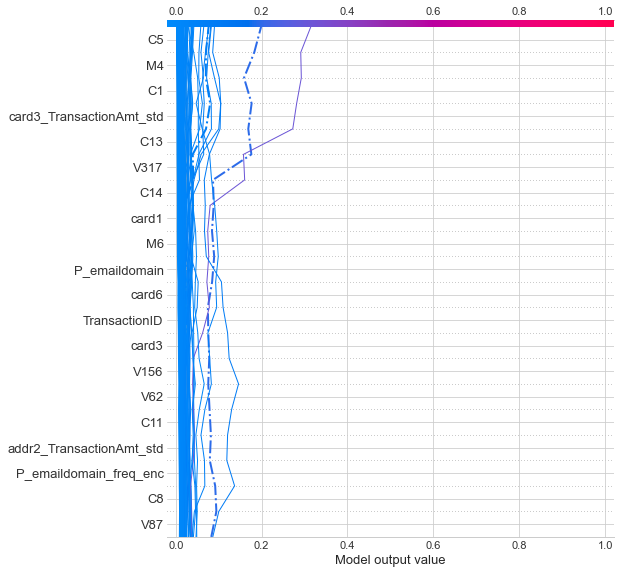

In [93]:
shap_values = explainer.shap_values(x_valid, y_valid)
y_pred = (shap_values.sum(1) + expected_value) > 0

misclassified = y_pred != y_valid
shap.decision_plot(
    expected_value, shap_values[:100], features_display.iloc[:100], link='logit', highlight=misclassified[:100]
)

- А среди 100 наблюдений заметны и выбросы и некорректные значения

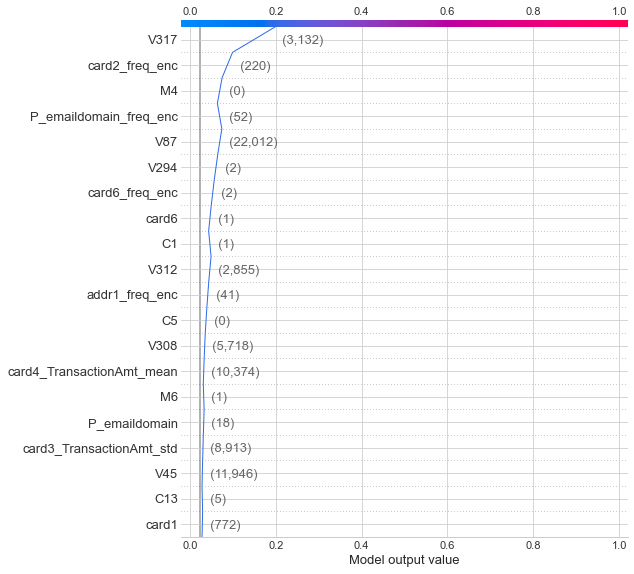

In [101]:
#Вывел график с одним из наблюдений, где получили неверное предсказание, но каких-то выводов по нему сделать не могу
shap.decision_plot(
    expected_value, shap_values[1], features_display.iloc[1, :], link='logit', highlight=misclassified.iloc[8267]
)